In [157]:
!pip install tslearn

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 38.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   --------------------- ------------------ 14.9/28.1 MB 78.1 MB/s eta 0:00:01
   ---------------------------------------  28.0/28.1 MB 74.1 MB/s eta 0:00:01
   ---------------------------------------- 28.1/28.1 MB 63.6 MB/s eta 0:00:00


In [187]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape


In [172]:
df = pd.read_csv("datatraitee_Et1_RetD_2021-01-01_00h10_2022-12-31_23h00.csv", sep=";")
print(df.head())
data=df.copy()

                     hc_date Text(degC) GloOr1(Wpm2) GloOr2(Wpm2)  \
0  2021-01-01 02:00:00+01:00        5,2            0            0   
1  2021-01-01 03:00:00+01:00        4,2            0            0   
2  2021-01-01 04:00:00+01:00        4,4            0            0   
3  2021-01-01 05:00:00+01:00        3,3            0            0   
4  2021-01-01 06:00:00+01:00        1,7            0            0   

    Tamb(degC)  mode() Tcsich(degC) Tcsifr(degC) ConsoCh(kWh) ConsoFr(kWh)  \
0  19,97272727     2.0  18,45454545  25,86363636   733783,126   271275,277   
1         19,9     2.0  18,45454545  25,86363636   733783,126   271275,277   
2  19,84545455     2.0  18,45454545  25,86363636   733783,126   271275,277   
3  19,60909091     2.0  18,45454545  25,86363636   733783,126   271275,277   
4  19,21818182     2.0  18,45454545  25,86363636   733783,126   271275,277   

   ... Twout(degC) Twin(degC)  Puisch(W) Puisfr(W) AppEBu(W) AppEEc(W)  \
0  ...       27,63      27,54          0  

### Traitement des valeurs manquantes


Dans dataset , il y a plusieurs valeurs manquantes. Pour les remplir, j'ai utilisé l'interpolation.

L'interpolation remplace les valeurs manquantes en utilisant les valeurs voisines, en traçant une ligne droite entre elles. Cela permet d'estimer les valeurs manquantes .


#### Résultat :
Après l'interpolation,  certaines lignes peuvent encore contenir des NaN si elles étaient situées au début ou à la fin des séries de données.

#### Étapes :
1. Application de l'interpolation linéaire pour remplir les NaN.
2. Suppression des lignes restantes avec des NaN après l'interpolation.

In [173]:
print(data.isnull().sum())


hc_date            0
Text(degC)        60
GloOr1(Wpm2)     410
GloOr2(Wpm2)     410
Tamb(degC)       454
mode()           454
Tcsich(degC)     454
Tcsifr(degC)     454
ConsoCh(kWh)       0
ConsoFr(kWh)       0
ConsoBu(kWh)     454
ConsoEc(kWh)     454
Comm(-)         2508
Deb(m3h)         454
Twout(degC)      454
Twin(degC)       454
Puisch(W)          0
Puisfr(W)          0
AppEBu(W)        463
AppEEc(W)        463
AppEqu(W)        463
day                0
Occ(0ou1)          0
AppPeo(W)          0
dtype: int64


In [174]:
data2=data.interpolate(method='linear', inplace=False)
data2 = data2.dropna()
print(data2.isnull().sum())


hc_date         0
Text(degC)      0
GloOr1(Wpm2)    0
GloOr2(Wpm2)    0
Tamb(degC)      0
mode()          0
Tcsich(degC)    0
Tcsifr(degC)    0
ConsoCh(kWh)    0
ConsoFr(kWh)    0
ConsoBu(kWh)    0
ConsoEc(kWh)    0
Comm(-)         0
Deb(m3h)        0
Twout(degC)     0
Twin(degC)      0
Puisch(W)       0
Puisfr(W)       0
AppEBu(W)       0
AppEEc(W)       0
AppEqu(W)       0
day             0
Occ(0ou1)       0
AppPeo(W)       0
dtype: int64


C:\Users\joeto\AppData\Local\Temp\ipykernel_1804\71235722.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data2=data.interpolate(method='linear', inplace=False)


In [175]:
hc_date = data2['hc_date']
day=data2['day']

data2 = data2.replace(',', '.', regex=True).apply(pd.to_numeric, errors='ignore')

scaler = StandardScaler()
data2_scaled = data2.drop(columns=['hc_date','day'])  
data2_scaled = pd.DataFrame(scaler.fit_transform(data2_scaled), columns=data2_scaled.columns)

data2_scaled.insert(0, 'hc_date', hc_date)
data2_scaled.insert(1, 'day', day)

print(data2_scaled.head()) 

C:\Users\joeto\AppData\Local\Temp\ipykernel_1804\1652224042.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data2 = data2.replace(',', '.', regex=True).apply(pd.to_numeric, errors='ignore')


                     hc_date         day  Text(degC)  GloOr1(Wpm2)  \
0  2021-01-01 02:00:00+01:00  01/01/2021   -1.237888     -0.616665   
1  2021-01-01 03:00:00+01:00  01/01/2021   -1.363600     -0.616665   
2  2021-01-01 04:00:00+01:00  01/01/2021   -1.338458     -0.616665   
3  2021-01-01 05:00:00+01:00  01/01/2021   -1.476741     -0.616665   
4  2021-01-01 06:00:00+01:00  01/01/2021   -1.677879     -0.616665   

   GloOr2(Wpm2)  Tamb(degC)    mode()  Tcsich(degC)  Tcsifr(degC)  \
0      -0.62981   -1.452042 -0.008768     -0.044385     -0.298471   
1      -0.62981   -1.485351 -0.008768     -0.044385     -0.298471   
2      -0.62981   -1.510332 -0.008768     -0.044385     -0.298471   
3      -0.62981   -1.618587 -0.008768     -0.044385     -0.298471   
4      -0.62981   -1.797624 -0.008768     -0.044385     -0.298471   

   ConsoCh(kWh)  ...  Deb(m3h)  Twout(degC)  Twin(degC)  Puisch(W)  Puisfr(W)  \
0      0.414927  ... -0.882475     0.900549    0.614790   -0.22709   -0.21189   
1 

### Analyse de la Corrélation et Réduction de Dimensionnalité avec PCA

D'après la matrice de corrélation, certaines variables présentent des corrélations fortes supérieures à un seuil de **0.75**. Ces variables sont fortement corrélées entre elles, ce qui peut créer des problèmes de redondance dans les données et augmenter la complexité du modèle, ce qui peut entraîner un risque de **overfitting**.

Voici un exemple de variables fortement corrélées :

| Variable 1        | Variable 2        | Corrélation |
|-------------------|-------------------|-------------|
| Tamb(degC)        | Text(degC)        | 0.862266    |
| ConsoCh(kWh)      | ConsoEc(kWh)      | -0.820382   |
| ConsoBu(kWh)      | ConsoCh(kWh)      | -0.821312   |
| ConsoBu(kWh)      | ConsoEc(kWh)      | 0.997938    |
| Twin(degC)        | Twout(degC)       | 0.792914    |
| AppEBu(W)         | AppEqu(W)         | 0.973758    |
| AppEBu(W)         | AppPeo(W)         | 0.890164    |
| AppEEc(W)         | AppEqu(W)         | 0.785444    |
| AppEqu(W)         | AppPeo(W)         | 0.922035    |
| AppPeo(W)         | Occ(0ou1)         | 0.818674    |

Pour simplifier le calcul et réduire l'overfitting, j'ai appliqué  **PCA**. 

En réduisant ces caractéristiques redondantes à un nombre plus faible de composantes principales, on simplifie les calculs tout en conservant les informations essentielles, ce qui améliore la performance du modèle.


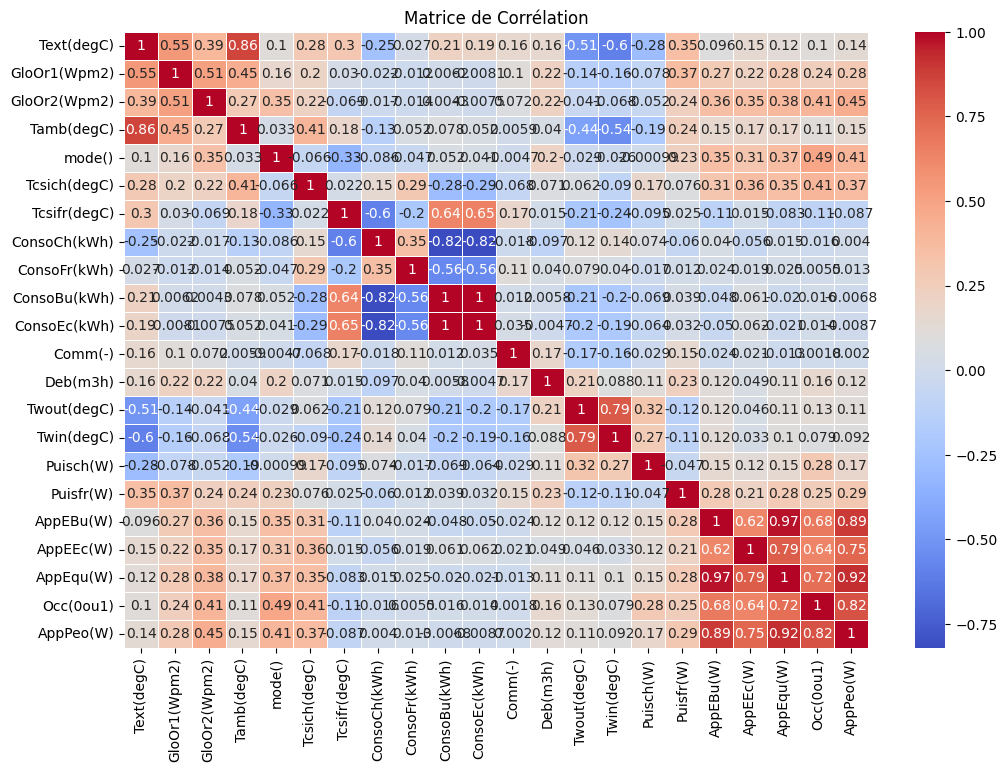

In [176]:
data2_scaled2 = data2_scaled.drop(columns=['hc_date','day'])  

correlation_matrix = data2_scaled2.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

In [177]:
threshold = 0.75

high_correlation = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]

high_correlation = high_correlation.stack().reset_index()

high_correlation = high_correlation[high_correlation['level_0'] < high_correlation['level_1']]
high_correlation.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_correlation = high_correlation[high_correlation['Variable 1'] != high_correlation['Variable 2']]

print(high_correlation)

      Variable 1    Variable 2  Correlation
4     Tamb(degC)    Text(degC)     0.862266
11  ConsoCh(kWh)  ConsoEc(kWh)    -0.820382
13  ConsoBu(kWh)  ConsoCh(kWh)    -0.821312
15  ConsoBu(kWh)  ConsoEc(kWh)     0.997938
23    Twin(degC)   Twout(degC)     0.792914
28     AppEBu(W)     AppEqu(W)     0.973758
29     AppEBu(W)     AppPeo(W)     0.890164
31     AppEEc(W)     AppEqu(W)     0.785444
35     AppEqu(W)     AppPeo(W)     0.922035
40     AppPeo(W)     Occ(0ou1)     0.818674


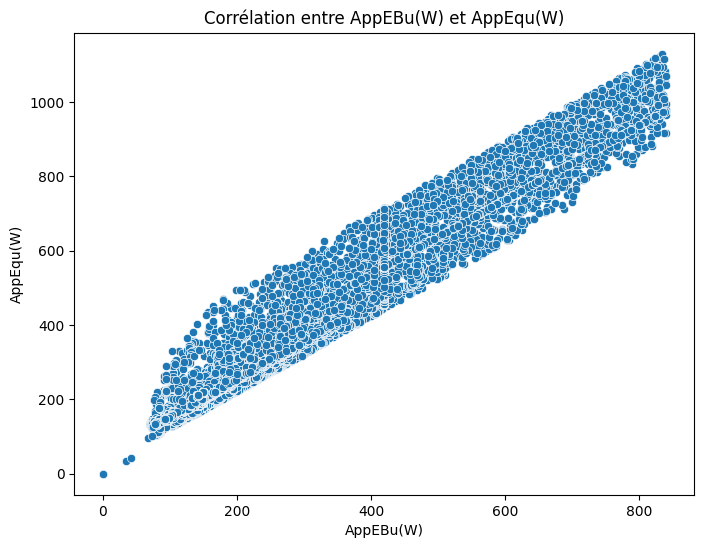

In [178]:
col1 = 'AppEBu(W)' 
col2 = 'AppEqu(W)'
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data[col1], y=data[col2])
plt.title(f'Corrélation entre {col1} et {col2}')
plt.show()

In [180]:
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(data2_scaled2)

pca_df = pd.DataFrame(pca_result, columns=[f'PCA_{i+1}' for i in range(pca_result.shape[1])])
final_df3 = pd.concat([data2_scaled[['hc_date', 'day']], pca_df], axis=1)

final_df3.to_csv('data_final2.csv', index=False)



In [181]:
final_df3['hc_date'] = pd.to_datetime(final_df3['hc_date'], errors='coerce', utc=True)
final_df3['hc_date'] = final_df3['hc_date'].dt.tz_localize(None)
final_df3['hour'] = final_df3['hc_date'].dt.hour
final_df3['date'] = final_df3['hc_date'].dt.date 

### Clustering 

J'ai utilisé 3 méthodes de clustering pour comparer laquelle est la plus adaptée à notre fichier CSV :

- **K-Means classique**
- **K-Means avec DTW**
- **KShape**

#### Inertie :

- **K-Means classique** : 30638.61
- **K-Means DTW** : 2530.63
- **KShape** : 4468.07

L'inertie mesure la qualité des groupes formésL ( calculée en sommant la distance entre chaque point et son centroïde). Moins l'inertie est élevée, mieux c'est. 

**K-Means DTW** a l'inertie la plus basse, donc c'est la méthode la plus adaptée.


In [183]:

pca_series_1 = final_df3.pivot_table(index='date', columns='hour', values='PCA_1')
pca_series_1 = pca_series_1.dropna()

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_series_1)

pca_series_1['cluster'] = clusters

pca_series_1.to_csv('kmeans.csv', index=False)



In [193]:
print(pca_series_1)

hour             0.0       1.0       2.0       3.0       4.0       5.0  \
date                                                                     
2021-01-02 -2.690055 -2.704248 -2.690587 -2.685637 -2.725480 -2.732162   
2021-01-03 -2.743359 -2.764249 -2.756521 -2.769176 -2.776683 -2.761954   
2021-01-04 -2.343751 -2.402371 -2.432050 -2.473419 -2.463633 -2.415052   
2021-01-05 -1.710333 -1.720225 -1.744487 -1.766525 -1.808005 -1.761191   
2021-01-06 -1.555719 -1.613957 -1.644021 -1.633906 -1.640807 -1.607416   
...              ...       ...       ...       ...       ...       ...   
2022-11-19 -2.313164 -2.335055 -2.396505 -2.390024 -2.386495 -2.297607   
2022-11-21 -2.262823 -2.258653 -2.259414 -2.277767 -2.317155 -2.318292   
2022-11-22 -2.368020 -2.413844 -2.413055 -2.415585 -2.434330 -2.438423   
2022-11-23 -2.326739 -2.295048 -2.298060 -2.302119 -2.314950 -2.298480   
2022-11-24 -2.358983 -2.335978 -2.333473 -2.343014 -2.336703 -2.313888   

hour             6.0       7.0       

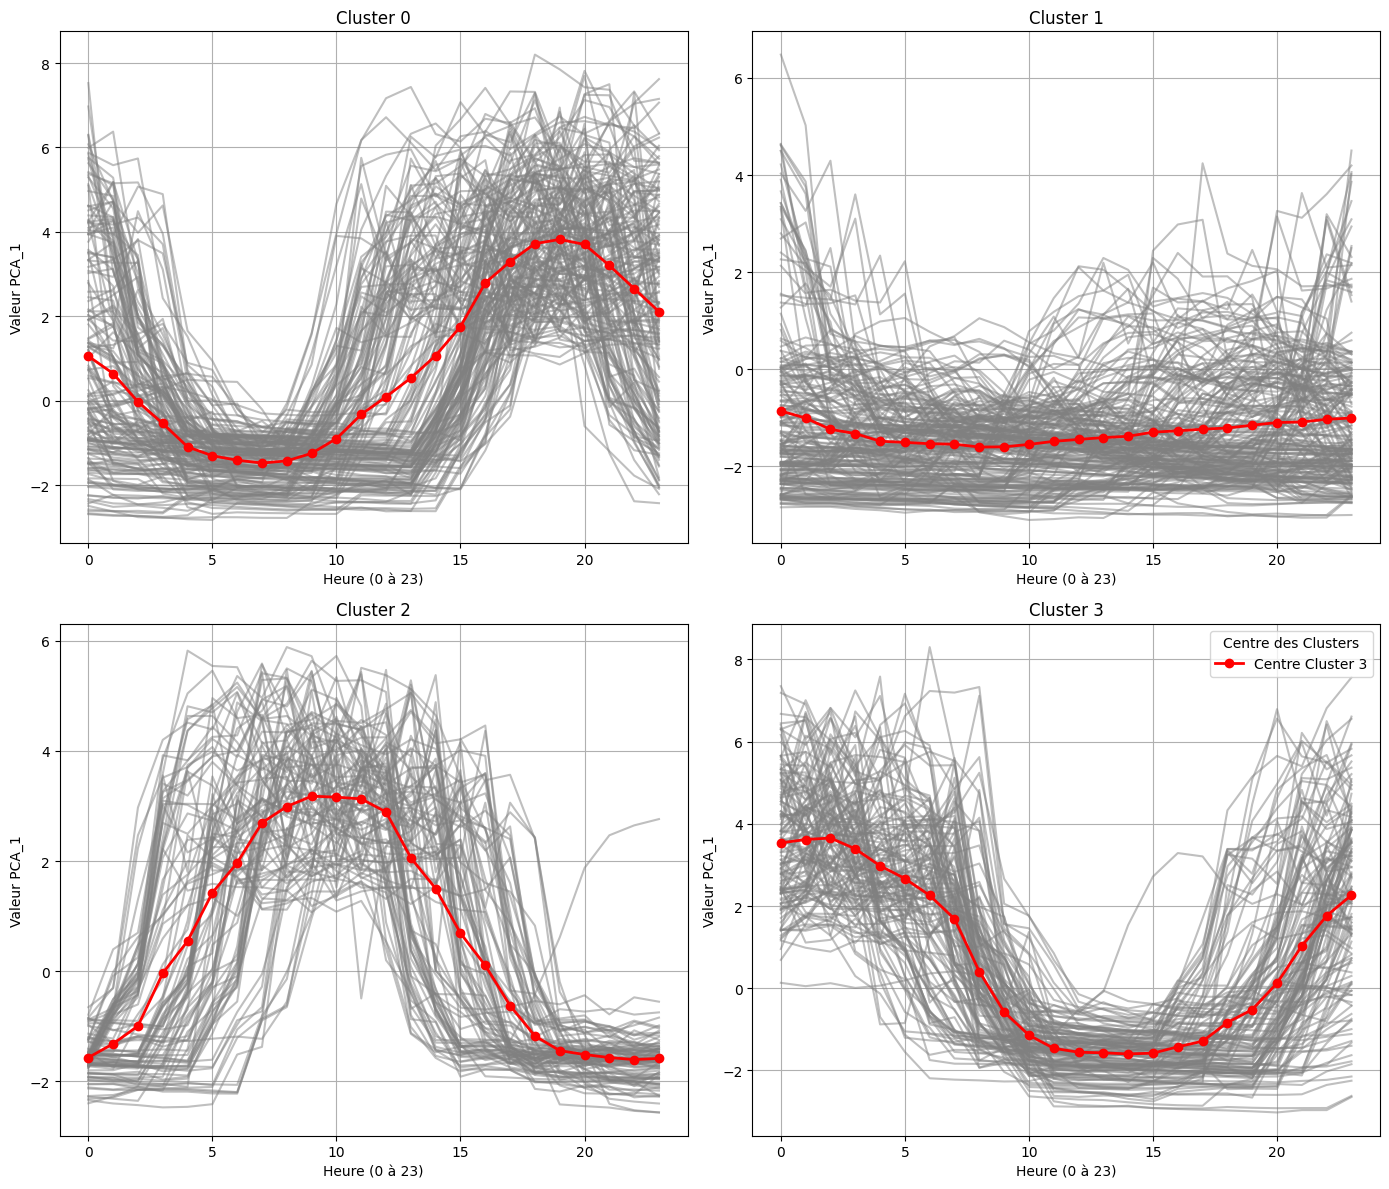

In [184]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  
for cluster_id in range(kmeans.n_clusters):
    cluster_data = pca_series_1[pca_series_1['cluster'] == cluster_id]
    for day in cluster_data.index:
        axes[cluster_id // 2, cluster_id % 2].plot(cluster_data.columns[:-1], cluster_data.loc[day, cluster_data.columns[:-1]], color='gray', alpha=0.5)
    axes[cluster_id // 2, cluster_id % 2].plot(cluster_data.columns[:-1], kmeans.cluster_centers_[cluster_id], marker='o', label=f"Centre Cluster {cluster_id}", color='red', linewidth=2)
    axes[cluster_id // 2, cluster_id % 2].set_title(f"Cluster {cluster_id}")
    axes[cluster_id // 2, cluster_id % 2].set_xlabel("Heure (0 à 23)")
    axes[cluster_id // 2, cluster_id % 2].set_ylabel("Valeur PCA_1")
    axes[cluster_id // 2, cluster_id % 2].grid(True)

plt.legend(title="Centre des Clusters", loc="best")
plt.tight_layout()
plt.show()

In [185]:

pca_series_2 = final_df3.pivot_table(index='date', columns='hour', values='PCA_1')
pca_series_2 = pca_series_2.dropna()

ts_data = to_time_series_dataset(pca_series_2.values)

kmeans_dtw = TimeSeriesKMeans(n_clusters=4, metric="dtw", random_state=42)
clusters = kmeans_dtw.fit_predict(ts_data)


pca_series_2['cluster'] = clusters
pca_series_2.to_csv('kmeans_dtw.csv', index=False)


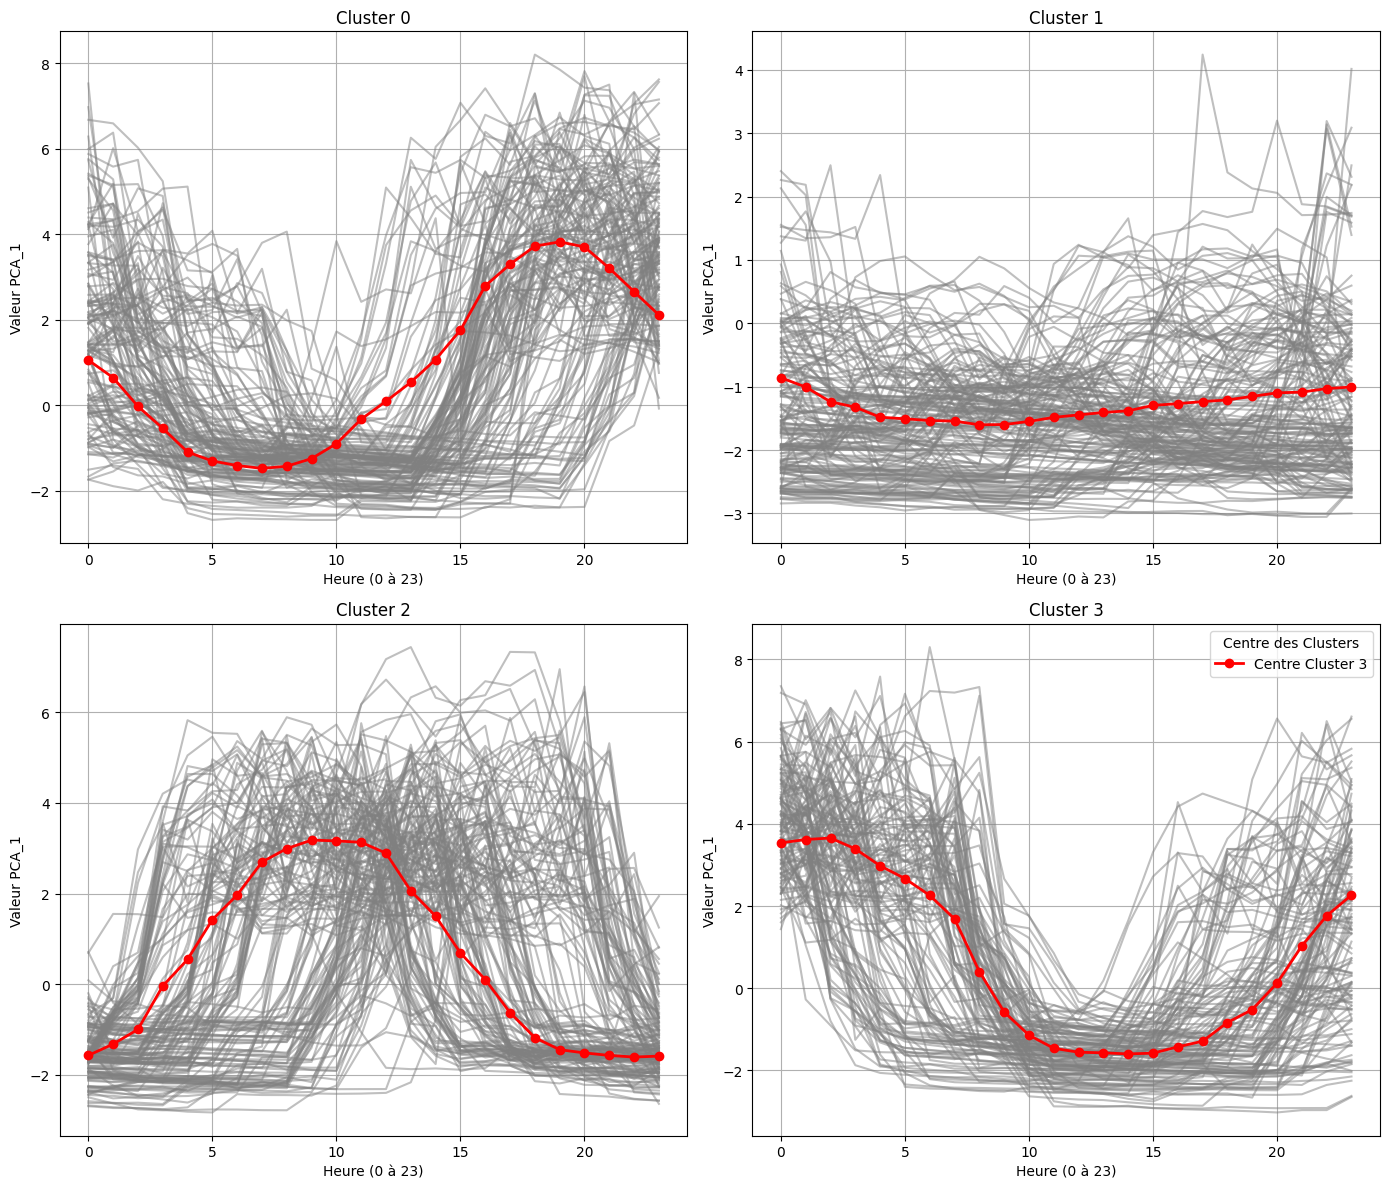

In [192]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  
for cluster_id in range(kmeans_dtw.n_clusters):
    cluster_data = pca_series_2[pca_series_2['cluster'] == cluster_id]
    for day in cluster_data.index:
        axes[cluster_id // 2, cluster_id % 2].plot(cluster_data.columns[:-1], cluster_data.loc[day, cluster_data.columns[:-1]], color='gray', alpha=0.5)
    axes[cluster_id // 2, cluster_id % 2].plot(cluster_data.columns[:-1], kmeans.cluster_centers_[cluster_id], marker='o', label=f"Centre Cluster {cluster_id}", color='red', linewidth=2)
    axes[cluster_id // 2, cluster_id % 2].set_title(f"Cluster {cluster_id}")
    axes[cluster_id // 2, cluster_id % 2].set_xlabel("Heure (0 à 23)")
    axes[cluster_id // 2, cluster_id % 2].set_ylabel("Valeur PCA_1")
    axes[cluster_id // 2, cluster_id % 2].grid(True)

plt.legend(title="Centre des Clusters", loc="best")
plt.tight_layout()
plt.show()

In [188]:
pca_series_3 = final_df3.pivot_table(index='date', columns='hour', values='PCA_1')
pca_series_3 = pca_series_3.dropna()
ts_data = to_time_series_dataset(pca_series_3.values)

kshape = KShape(n_clusters=4, random_state=42)
clusters = kshape.fit_predict(ts_data)

pca_series_3['cluster'] = clusters

pca_series_3.to_csv('kshape.csv', index=False)


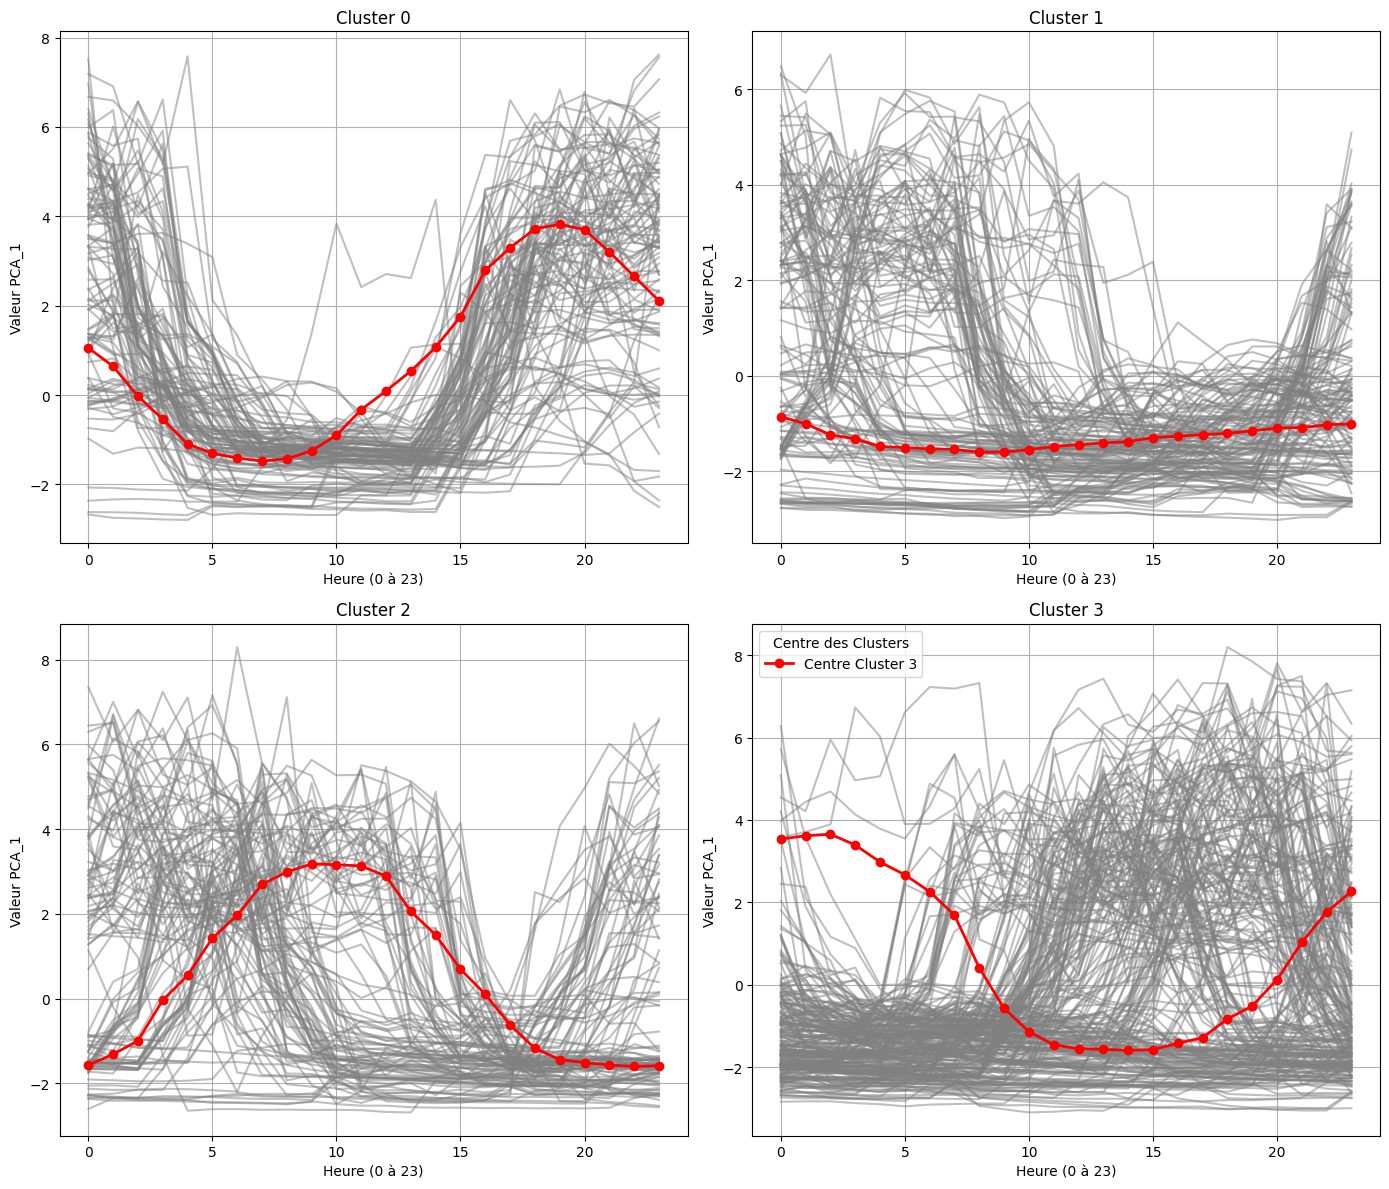

In [191]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  
for cluster_id in range(kshape.n_clusters):
    cluster_data = pca_series_3[pca_series_3['cluster'] == cluster_id]
    for day in cluster_data.index:
        axes[cluster_id // 2, cluster_id % 2].plot(cluster_data.columns[:-1], cluster_data.loc[day, cluster_data.columns[:-1]], color='gray', alpha=0.5)
    axes[cluster_id // 2, cluster_id % 2].plot(cluster_data.columns[:-1], kmeans.cluster_centers_[cluster_id], marker='o', label=f"Centre Cluster {cluster_id}", color='red', linewidth=2)
    axes[cluster_id // 2, cluster_id % 2].set_title(f"Cluster {cluster_id}")
    axes[cluster_id // 2, cluster_id % 2].set_xlabel("Heure (0 à 23)")
    axes[cluster_id // 2, cluster_id % 2].set_ylabel("Valeur PCA_1")
    axes[cluster_id // 2, cluster_id % 2].grid(True)

plt.legend(title="Centre des Clusters", loc="best")
plt.tight_layout()
plt.show()

In [190]:
from tslearn.metrics import dtw

def dtw_inertia(series, labels, centroids):
    inertia = 0
    for i, serie in enumerate(series):
        inertia += dtw(serie, centroids[labels[i]])  # Distance DTW entre chaque série et son centroïde
    return inertia

# Inertie pour KMeans classique
inertia_kmeans = kmeans.inertia_  # Inertie classique

inertia_dtw = dtw_inertia(pca_series_1.values, kmeans_dtw.labels_, kmeans_dtw.cluster_centers_)

inertia_kshape = dtw_inertia(pca_series_1.values, kshape.labels_, kshape.cluster_centers_)

print("Inertie K-Means classique :", inertia_kmeans)
print("Inertie K-Means DTW (DTW Distorsion) :", inertia_dtw)
print("Inertie KShape (DTW Distorsion) :", inertia_kshape)


Inertie K-Means classique : 30638.61446454085
Inertie K-Means DTW (DTW Distorsion) : 2530.633539934288
Inertie KShape (DTW Distorsion) : 4468.068181129433


In [202]:
datafinal = data2.copy()
datafinal['hc_date'] = pd.to_datetime(datafinal['hc_date'], errors='coerce', utc=True)
datafinal['hc_date'] = datafinal['hc_date'].dt.tz_localize(None)
datafinal['date'] = datafinal['hc_date'].dt.date
datafinal['date'] = pd.to_datetime(datafinal['date'])
datafinal['cluster'] = datafinal['date'].map(pca_series_2.index.to_series().map(dict(zip(pca_series_2.index, clusters))))
datafinal = datafinal[datafinal['date'].isin(pca_series_2.index)]
datafinal.to_csv('datafinal_with_clusters.csv', index=False)


C:\Users\joeto\AppData\Local\Temp\ipykernel_1804\109145099.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  datafinal = datafinal[datafinal['date'].isin(pca_series_2.index)]


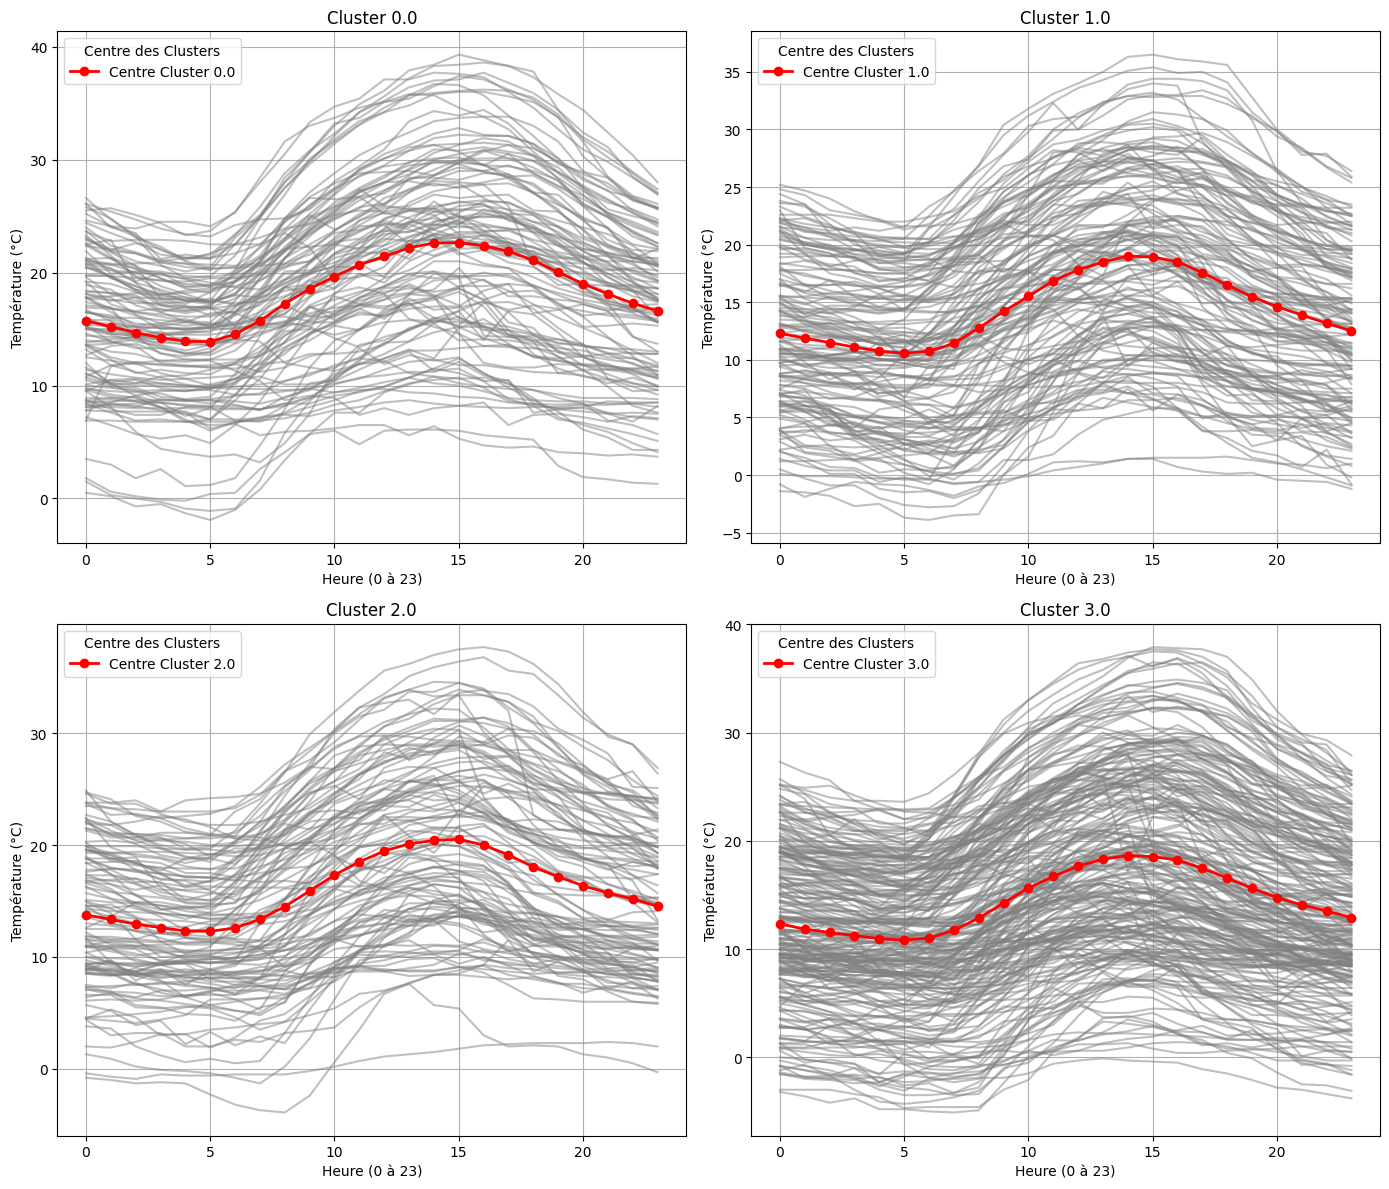

In [205]:
import matplotlib.pyplot as plt
import numpy as np

# Extraire l'heure
datafinal['hour'] = pd.to_datetime(datafinal['hc_date']).dt.hour

# Trouver les clusters uniques
unique_clusters = sorted(datafinal['cluster'].dropna().unique())  
n_clusters = len(unique_clusters)  

# Définir la disposition des sous-graphiques (ex: 2x2 pour 4 clusters, sinon s'adapte)
n_rows = int(np.ceil(n_clusters / 2))  
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 6 * n_rows))  

# S'assurer que 'axes' est un tableau 2D (important si n_clusters = 1)
if n_clusters == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])  

# Tracer chaque cluster
for i, cluster_id in enumerate(unique_clusters):
    row, col = divmod(i, 2)  # Trouver l'emplacement dans la grille
    ax = axes[row, col]  

    cluster_data = datafinal[datafinal['cluster'] == cluster_id]

    # Tracer toutes les courbes des jours appartenant à ce cluster
    for date, group in cluster_data.groupby(cluster_data['hc_date'].dt.date):
        ax.plot(group['hour'], group['Text(degC)'], color='gray', alpha=0.5)

    # Ajouter la courbe moyenne du cluster
    mean_curve = cluster_data.groupby('hour')['Text(degC)'].mean()
    ax.plot(mean_curve.index, mean_curve.values, marker='o', 
            label=f"Centre Cluster {cluster_id}", color='red', linewidth=2)

    # Titres et labels
    ax.set_title(f"Cluster {cluster_id}")
    ax.set_xlabel("Heure (0 à 23)")
    ax.set_ylabel("Température (°C)")
    ax.grid(True)
    ax.legend(title="Centre des Clusters")

# Ajustement de l'affichage
plt.tight_layout()
plt.show()
